In [9]:
from pyspark import SparkContext
import sys
import csv
import pandas as pd
import seaborn as sns
from time import time
from collections import Counter
from itertools import combinations
from matplotlib import pyplot as plt

def date_customer_product_pair(pairs, candidate_customers_bc):
    for pair in pairs:
        date_customer = pair[0].split('-')
        if date_customer[1] in candidate_customers_bc.value:
            yield (pair[0], [pair[1]])

def get_customer_product(iterations):
    for pair in iterations:
        date_customer = pair[0].split('-')
        yield (date_customer[1], [pair[1]])

def customer_filter(customer_infos,threshold=20):
    for customer_info in customer_infos:
        if len(set(customer_info[1]))>threshold:
            yield customer_info[0]

def partition_basket_cnt(baskets):
    local_cnt = []
    for basket in baskets:
        local_cnt.append(len(basket))
    yield local_cnt

In [2]:
pair_out_file = "./Customer_product.csv"
sc = SparkContext.getOrCreate()
minPartition = 15
raw_data = sc.textFile(pair_out_file,minPartition)
header = raw_data.first()
raw_data_without_header = raw_data.filter(lambda x: x != header)
# DATE-CUSTOMER_ID,PRODUCT_ID
clean_data = raw_data_without_header.mapPartitions(lambda x: csv.reader(x))
candidate_customers = clean_data.mapPartitions(lambda pairs: get_customer_product(pairs)).reduceByKey(lambda a, b: a + b).mapPartitions(
    lambda x: customer_filter(x,20)).collect()

print("Number of customer id after filter:",len(candidate_customers))

candidate_customers_bc = sc.broadcast(candidate_customers)

clean_baskets = clean_data.mapPartitions(lambda pairs: date_customer_product_pair(pairs, candidate_customers_bc)).reduceByKey(lambda a, b: a + b).map(lambda x: sorted(list(set(x[1]))))
print("Number of customer id after filter:",clean_baskets.count())

partition_local_basket_cnt = clean_baskets.mapPartitions(lambda x: partition_basket_cnt(x)).collect()
print([max(partition_local_basket_cnt[i]) for i in range(minPartition)])

Number of customer id after filter: 11875
Number of customer id after filter: 79337
[70, 89, 112, 102, 85, 65, 59, 82, 97, 103, 100, 82, 69, 89, 82]


In [5]:
basket_cnt = clean_baskets.map(lambda x: len(x)).collect()
basket_cnt_df = pd.DataFrame(basket_cnt,columns=['bsk_len'])

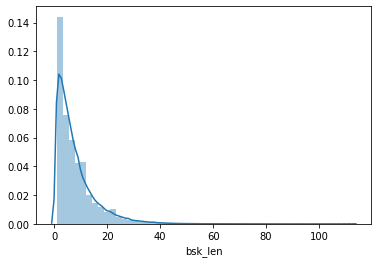

In [7]:
sns.distplot(basket_cnt_df["bsk_len"])

Text(0, 0.5, 'Frequency')

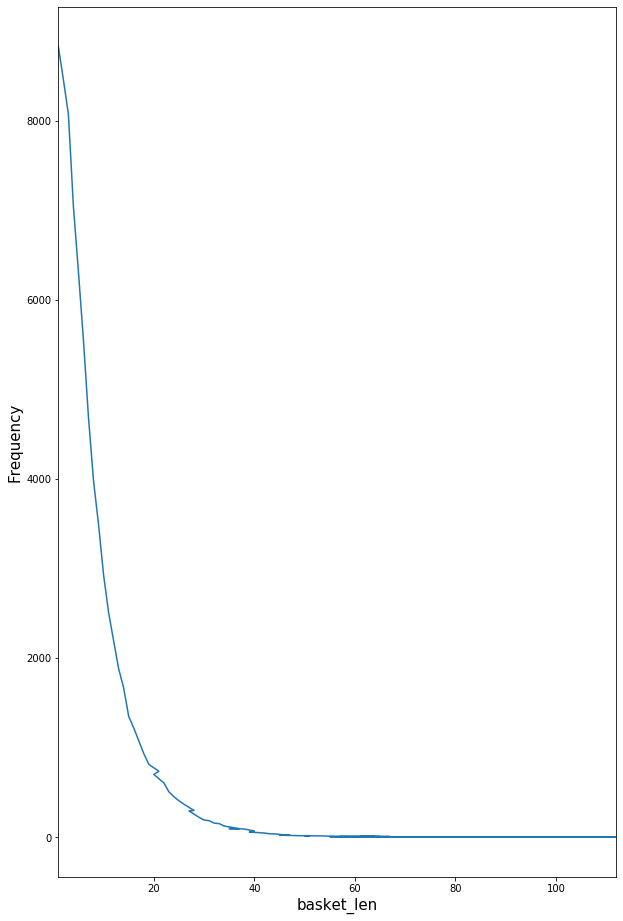

In [12]:
plt.figure(figsize=(10,16))
basket_cnt_df["bsk_len"].value_counts().plot()
plt.xlabel("basket_len",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
# plt.savefig("./corated_cnt.png",bbox_inches='tight',dpi=300)

In [20]:
basket_stat = basket_cnt_df["bsk_len"].value_counts().sort_index()

In [25]:
basket_stat.iloc[:30]

1     8829
2     8461
3     8073
4     7043
5     6312
6     5546
7     4686
8     3980
9     3490
10    2929
11    2509
12    2192
13    1880
14    1666
15    1348
16    1220
17    1076
18     933
19     812
20     700
21     736
22     605
23     506
24     451
25     406
26     367
27     293
28     298
29     221
30     191
Name: bsk_len, dtype: int64